### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

#### Задание:
 Используя данные из train.csv, построить
 модель для предсказания цен на недвижимость (квартиры).
 С помощью полученной модели предсказать
 цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor #, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [3]:
def best_model(X_train, X_test, y_train, y_test, models, plot=True, print_all=True, test_s=0.2, random_st=42):
    R2 = dict()
    R2_best = -1000
    for m in models:
        model = m
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2_coef = round(r2(y_test, y_pred), 3)
        if r2_coef > R2_best:
            best = model
            R2_best = round(r2(y_test, y_pred), 3)
            pred_values = y_pred
            
        #R2[model] =  round(r2(y_test, y_pred), 3)
        if print_all:
            print('R2 ', m, ' ', r2_coef)
    print('\n')
    print('BEST MODEL: ', best, '\nR2: ', R2_best)
    if plot:
        plt.figure(figsize=(10,10))
    
        sns.scatterplot(x=pred_values, y=y_test)
    
        plt.xlabel('Predicted values')
        plt.ylabel('True values')
        plt.title('True vs Predicted values')
        plt.show()
    return best     

In [4]:
test_s_ = 0.2
random_st_ = 42

## 1. Загрузка данных, изучение

In [5]:
df = pd.read_csv('train.csv')
columns_ = df.columns

In [6]:
df_test = pd.read_csv('test.csv')

**склеем данные, для одновременного наведения порядка в параметрах, а также мы получим преимущество при одновременной обработке всего обьема**

In [7]:
df = pd.concat([df, df_test])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 20 columns):
DistrictId       15000 non-null int64
Ecology_1        15000 non-null float64
Ecology_2        15000 non-null object
Ecology_3        15000 non-null object
Floor            15000 non-null int64
Healthcare_1     7825 non-null float64
Helthcare_2      15000 non-null int64
HouseFloor       15000 non-null float64
HouseYear        15000 non-null int64
Id               15000 non-null int64
KitchenSquare    15000 non-null float64
LifeSquare       11846 non-null float64
Price            10000 non-null float64
Rooms            15000 non-null float64
Shops_1          15000 non-null int64
Shops_2          15000 non-null object
Social_1         15000 non-null int64
Social_2         15000 non-null int64
Social_3         15000 non-null int64
Square           15000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 2.4+ MB


In [9]:
df = df[columns_]

In [10]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,8393.136933,50.693600,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,4850.111673,43.786257,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4188.750000,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8378.500000,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12594.250000,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.000000,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Вывод:

- необходимо восстановить LifeSquare и проверить разницу жилой площади и общей
- необходимо восстановить Healthcare_1
- "Ecology_2", "Ecology_3", "Shops_2" в несколько бинарных
- столбец Id не будем использовать при построении моделей
- проверить площадь кухни против площадь жилая KitchenSquare
- проверить количество этажей в доме HouseFloor
- проверить год постройки HouseYear
- очень сложно представить себе жилое помещение с 3 комнатами и площадью 4.823679, считаем что это ошибка ввода данных и восстановим эти данные Square
- есть квартиры с комнатами = 0 Rooms

In [11]:
print('LifeSquare missed   - ', pd.isna(df['LifeSquare']).value_counts()[1])
print('LifeSquare wrong    - ', (df['LifeSquare']<0.3*df['Square']).value_counts()[1])
print('LifeSquare wrong    - ', (df['LifeSquare']>df['Square']).value_counts()[1])
print('Healthcare_1 missed - ', pd.isna(df['Healthcare_1']).value_counts()[1])
print('KitchenSquare wrong>Square - ', (df['KitchenSquare']-df['Square']>0).value_counts()[1])
print('KitchenSquare wrong==0 - ', (df['KitchenSquare']==0).value_counts()[1])
print('Floor wrong Floor>HouseFloor    - ', (df['HouseFloor']-df['Floor']<0).value_counts()[1])
print('HouseFloor wrong==0    - ', (df['HouseFloor']==0).value_counts()[1])
print('HouseYear wrong     - ', df['HouseYear'].sort_values()[-3:].to_list())
print('Rooms wrong    - ', (df['Rooms']==0).value_counts()[1])
print('Square wrong - ', (df['Square']<10).value_counts()[1])

LifeSquare missed   -  3154
LifeSquare wrong    -  309
LifeSquare wrong    -  723
Healthcare_1 missed -  7175
KitchenSquare wrong>Square -  8
KitchenSquare wrong==0 -  1032
Floor wrong Floor>HouseFloor    -  2709
HouseFloor wrong==0    -  400
HouseYear wrong     -  [2020, 4968, 20052011]
Rooms wrong    -  10
Square wrong -  20


**Стратегия**

Восстанавливаем от меньшего количества пропущенных значений к большему. В конце построим модель для Price
0. Преобразуем категории в числовые
1. HouseYear - всего два значения
2. Rooms
3. Square
4. KitchenSquare
5. HouseFloor
6. LifeSquare
7. Floor
8. HealthCare_1
9. Price

## 2. Восстанавливаем

### 2.0. Добавление признаков
**Признаки "Ecology_2", "Ecology_3", "Shops_2" в несколько бинарных**

In [12]:
#df['DistrictId'] = df['DistrictId'].astype('str')
df = pd.get_dummies(df)

**преобразуем признак DistricId**

In [13]:
df['DistrictId'] = df['DistrictId'].astype('str')

In [14]:
district_size = df['DistrictId'].value_counts().reset_index()\
        .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,1242
1,1,996
2,23,829
3,6,768
4,9,426


In [15]:
df = df.merge(district_size, on='DistrictId', how='left')

**добавим признак размер дистрикта**

In [16]:
df['IsDistrictLarge'] = (df['DistrictSize']>100).astype(int)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 25 columns):
Id                 15000 non-null int64
DistrictId         15000 non-null object
Rooms              15000 non-null float64
Square             15000 non-null float64
LifeSquare         11846 non-null float64
KitchenSquare      15000 non-null float64
Floor              15000 non-null int64
HouseFloor         15000 non-null float64
HouseYear          15000 non-null int64
Ecology_1          15000 non-null float64
Social_1           15000 non-null int64
Social_2           15000 non-null int64
Social_3           15000 non-null int64
Healthcare_1       7825 non-null float64
Helthcare_2        15000 non-null int64
Shops_1            15000 non-null int64
Price              10000 non-null float64
Ecology_2_A        15000 non-null uint8
Ecology_2_B        15000 non-null uint8
Ecology_3_A        15000 non-null uint8
Ecology_3_B        15000 non-null uint8
Shops_2_A          15000 non-null u

In [18]:
columns_full = df.columns

### 2.1. HouseYear

In [19]:
df['HouseYear'].sort_values().tail(2)

4189        4968
1497    20052011
Name: HouseYear, dtype: int64

**Используем среднее значение сгруппированное до DistrictId, для заполнения данных**

In [20]:
houseyear_median = df.groupby(['DistrictSize'])['HouseYear'].median()\
                .reset_index().rename(columns={'HouseYear':'hy_m'})
df_temp = df.merge(houseyear_median, on='DistrictSize', how='left')
df_temp.loc[df_temp['HouseYear']>2021,'HouseYear']=df_temp['hy_m']
df = df_temp.drop(['hy_m'], axis=1)

In [21]:
df['HouseYear'].sort_values().tail(2)

6735     2020.0
13255    2020.0
Name: HouseYear, dtype: float64

In [22]:
df_hy = df.copy()

### 2.2. Rooms

In [23]:
df_rooms = df_hy.copy()
df = df_rooms.copy()

In [24]:
# в чем проблема
#df = df_rooms.copy()
print('Rooms wrong    - ', (df['Rooms']==0).value_counts()[1])

Rooms wrong    -  10


In [25]:
df_rooms = df.copy()
# определяем таргет и параметры датасета 
# убираем параметры с некорретными значениями
feature_ = [
    #'Id', 
    #'DistrictId', 
    #'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
    #'Floor', 'HouseFloor', 
    'HouseYear', 
    'Ecology_1', 'Social_1', 'Social_2',
    'Social_3', 
    #'Healthcare_1', 
    'Helthcare_2', 'Shops_1', 
    #'Price',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
    'Shops_2_B', 'DistrictSize', 'IsDistrictLarge'
            ]
target_ = 'Rooms'

feature_std = df[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

**изучим распределение**

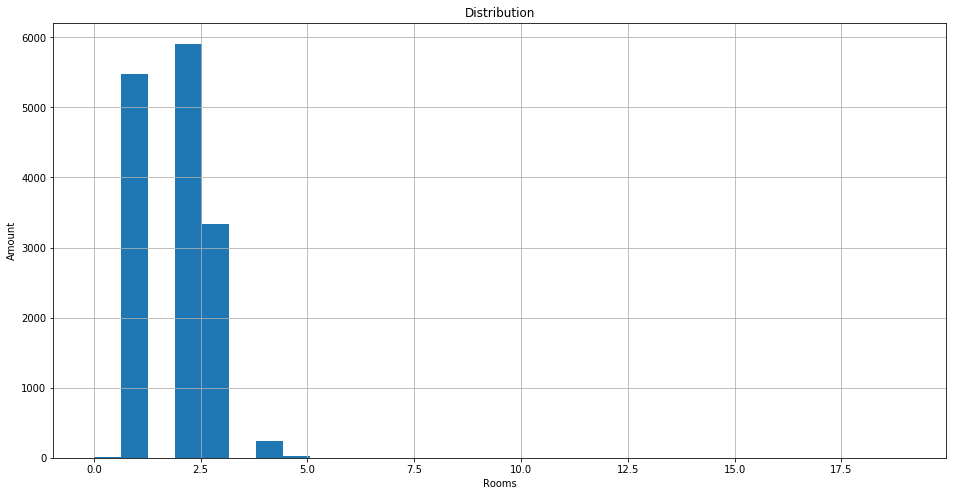

In [26]:
#df.info()
# изучем распределение
plt.figure(figsize = (16, 8))

df[target_].hist(bins=30)
plt.ylabel('Amount')
plt.xlabel(target_)

plt.title('Distribution')
plt.show()

**Используем среднее значение по DistrictSize для заполнения данных**

In [27]:
column = 'Rooms'
rooms_median = df[df['Rooms']!=0].groupby(['DistrictSize'])[column].median()\
                .reset_index().rename(columns={column:'temp_c'})
df_temp = df.merge(rooms_median, on='DistrictSize', how='left')
df_temp.loc[df_temp['Rooms']==0,column]=df_temp['temp_c']
df = df_temp.drop(['temp_c'], axis=1)

In [28]:
print('Rooms wrong\n', (df['Rooms']==0).value_counts(), sep='')

Rooms wrong
False    15000
Name: Rooms, dtype: int64


In [29]:
#просто среднее
#print('Медиана: ',int(round(df[target_].agg('median'))))
#print('Среднее: ',int(round(df[target_].agg('mean'))))
#df.loc[df[target_] == 0, target_] = int(round(df[target_].agg('mean')))
#df[df[target_]==0][target_]

In [30]:
df_rooms_new = df.copy()

In [31]:
df_rooms_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 25 columns):
Id                 15000 non-null int64
DistrictId         15000 non-null object
Rooms              15000 non-null float64
Square             15000 non-null float64
LifeSquare         11846 non-null float64
KitchenSquare      15000 non-null float64
Floor              15000 non-null int64
HouseFloor         15000 non-null float64
HouseYear          15000 non-null float64
Ecology_1          15000 non-null float64
Social_1           15000 non-null int64
Social_2           15000 non-null int64
Social_3           15000 non-null int64
Healthcare_1       7825 non-null float64
Helthcare_2        15000 non-null int64
Shops_1            15000 non-null int64
Price              10000 non-null float64
Ecology_2_A        15000 non-null uint8
Ecology_2_B        15000 non-null uint8
Ecology_3_A        15000 non-null uint8
Ecology_3_B        15000 non-null uint8
Shops_2_A          15000 non-null

### 2.3. Square

In [32]:
# сохраняем копию наших данных
df = df_rooms_new.copy()
df_square = df.copy() 

In [33]:
#в чем проблема
print('Square wrong - ', (df['Square']<10).value_counts()[1])

Square wrong -  20


**1. определим цель и параметры**

In [34]:
# определяем таргет и параметры датасета 
# убираем параметры с некорретными значениями
feature_ = [
    #'Id', 
    #'DistrictId', 
    'Rooms', 
    #'Square', 'LifeSquare', 'KitchenSquare',
    #'Floor', 'HouseFloor', 
    'HouseYear', 
    'Ecology_1', 'Social_1', 'Social_2',
    'Social_3', 
    #'Healthcare_1', 
    'Helthcare_2', 'Shops_1', 
    #'Price',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
    'Shops_2_B', 'DistrictSize', 'IsDistrictLarge'
            ]
target_ = 'Square'

feature_std = df[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

**2. изучим распределение**

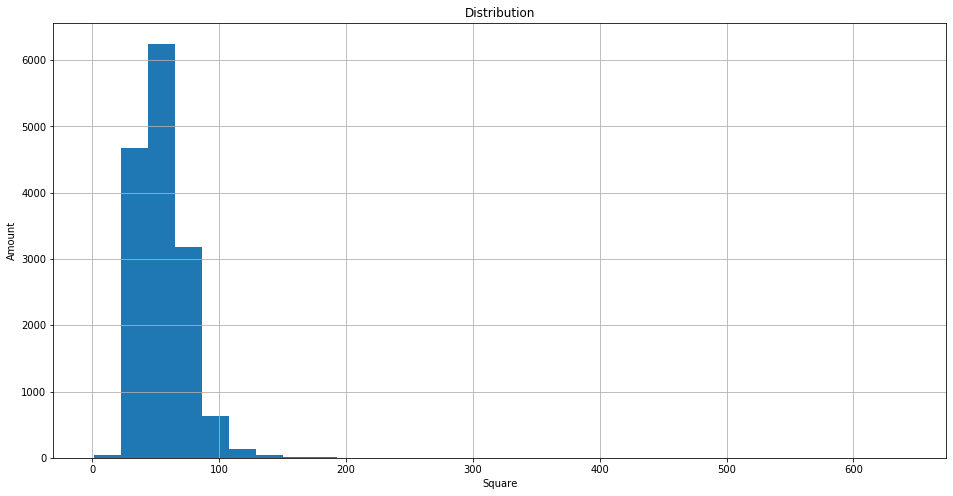

In [35]:
#df.info()
# изучем распределение
plt.figure(figsize = (16, 8))

df[target_].hist(bins=30)
plt.ylabel('Amount')
plt.xlabel(target_)

plt.title('Distribution')
plt.show()

нормальное распределени, поэтому попробуем испоьлзовать линейную регрессию для восстановления данных

**3. определим тренировочный датасет**

In [36]:
df = df[df['Square']>=10].reset_index()
df.drop(['index'], axis=1, inplace=True)
df_train = df.copy()
#df_s.info()

**4. уберем выбросы**

In [37]:
#так как распределение похожа на нормальное и сильные выборсы, то почистим их)))
mean = df[target_].to_numpy().mean()
var = df[target_].to_numpy().var()**(1/2)
print(mean)
print(var)
print(len(df[df[target_]>(mean+3*var)]))
df.drop(df[df[target_]>(mean+3*var)].index.to_list(),inplace=True)
df.reset_index(inplace=True)

56.43083147337487
20.345438187033693
150


**5. станартизируем и выделяем датасеты для модели**

In [38]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_std])
df[feature_std] = pd.DataFrame(scl_f, columns=feature_std)
X = df[feature_]
y = df[target_]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s_, random_state=random_st_)

**6. выберем лучшую модель**



BEST MODEL:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
R2:  0.806


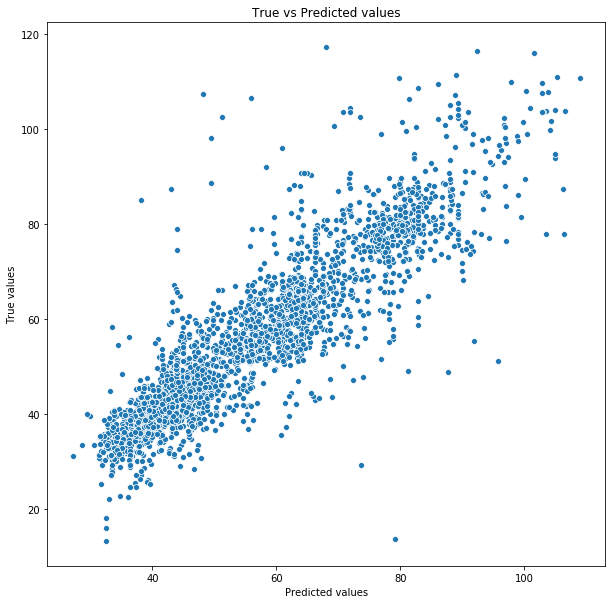

In [39]:
model = best_model(X_train, X_test, y_train, y_test,
                   [LinearRegression(), Lasso(), RandomForestRegressor()], 
                   plot=True, print_all=False)

**7. подберем оптимальные параметры для модели**

In [40]:
#model = model
param={'n_estimators':[150, 300], 'max_depth':[9, 12]}
gd=GridSearchCV(model, param, scoring='r2',cv = KFold(n_splits=3,random_state = 42))
gd.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,

In [41]:
gd.best_params_

{'max_depth': 12, 'n_estimators': 300}

In [42]:
model_1 = RandomForestRegressor(max_depth=gd.best_params_['max_depth'], 
                                       n_estimators=gd.best_params_['n_estimators'], 
                                       random_state=random_st_
                                      )
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.91
MAE:	3.128
MSE:	26.184


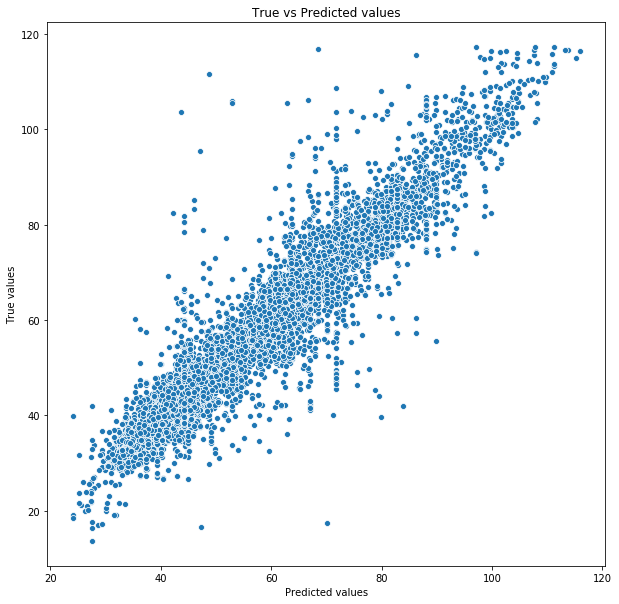

R2:	0.811
MAE:	4.814
MSE:	54.567


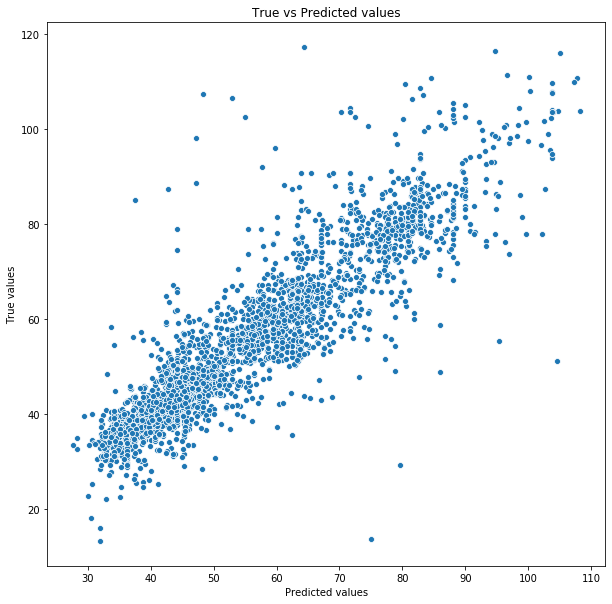

In [43]:
y_pred = model.predict(X_train)
evaluate_preds(y_train, y_pred)

y_pred_t = model.predict(X_test)
evaluate_preds(y_test, y_pred_t)

**8. восстанавливаем данные**

In [44]:
df = df_square.copy()

df = df[df[target_]<10].reset_index()
df.drop(['index'], axis=1, inplace=True)

In [45]:
df_std = df.copy()
scl_f = scl.transform(df_std[feature_std])
df_std[feature_std] = pd.DataFrame(scl_f, columns=feature_std)

X = df_std[feature_]
target = model.predict(X)

df[target_] =  pd.DataFrame(target)

In [46]:
#df = pd.concat([df_square[df_square[target_]>=10], df], ignore_index=True)
df = pd.concat([df_train, df], ignore_index=True)
df = df[columns_full]

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 25 columns):
Id                 15000 non-null int64
DistrictId         15000 non-null object
Rooms              15000 non-null float64
Square             15000 non-null float64
LifeSquare         11846 non-null float64
KitchenSquare      15000 non-null float64
Floor              15000 non-null int64
HouseFloor         15000 non-null float64
HouseYear          15000 non-null float64
Ecology_1          15000 non-null float64
Social_1           15000 non-null int64
Social_2           15000 non-null int64
Social_3           15000 non-null int64
Healthcare_1       7825 non-null float64
Helthcare_2        15000 non-null int64
Shops_1            15000 non-null int64
Price              10000 non-null float64
Ecology_2_A        15000 non-null uint8
Ecology_2_B        15000 non-null uint8
Ecology_3_A        15000 non-null uint8
Ecology_3_B        15000 non-null uint8
Shops_2_A          15000 non-null

In [48]:
df_square_new = df.copy()

**9. результат**

In [49]:
print('Square wrong\n', (df['Square']<10).value_counts(), sep='')

Square wrong
False    15000
Name: Square, dtype: int64


In [50]:
#df_square_new = df.copy()
df = df_square_new.copy()

### 2.4. KitchenSquare

In [51]:
# в чем проблема
print('KitchenSquare wrong>LifeSquare - ', (df['KitchenSquare']-df['Square']>0).value_counts()[1])
print('KitchenSquare wrong==0 - ', (df['KitchenSquare']==0).value_counts()[1])

KitchenSquare wrong>LifeSquare -  8
KitchenSquare wrong==0 -  1032


**1. определим цель и параметры**

In [52]:
df_KitchenSquare = df.copy()
# определяем таргет и параметры датасета 
# убираем параметры с некорретными значениями
feature_ = [
    #'Id', 
    #'DistrictId', 
    'Rooms', 
    'Square',
    #'LifeSquare', 'KitchenSquare',
    #'Floor', 'HouseFloor', 
    'HouseYear', 
    'Ecology_1', 'Social_1', 'Social_2',
    'Social_3', 
    #'Healthcare_1', 
    'Helthcare_2', 'Shops_1', 
    #'Price',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
    'Shops_2_B', 'DistrictSize', 'IsDistrictLarge'
            ]
target_ = 'KitchenSquare'

feature_std = df[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

**2. изучим распределение**

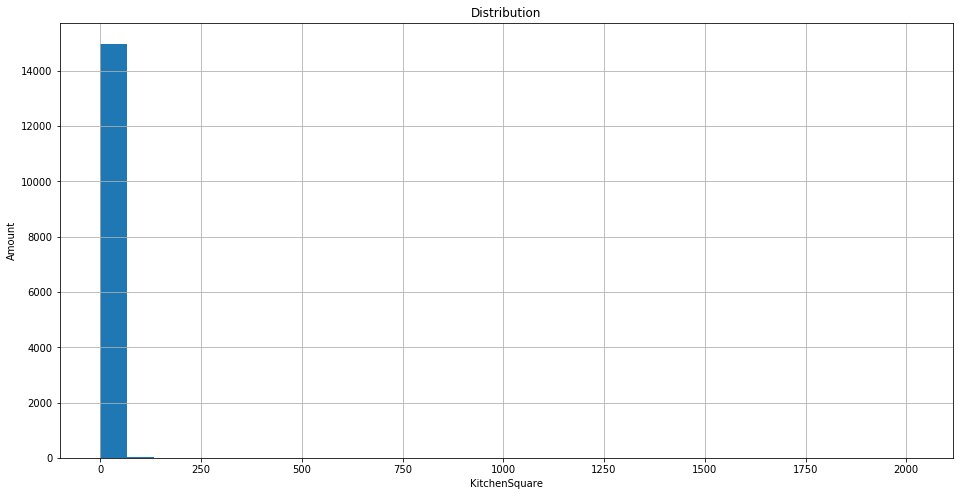

In [53]:
#df.info()
# изучем распределение
plt.figure(figsize = (16, 8))

df[target_].hist(bins=30)
plt.ylabel('Amount')
plt.xlabel(target_)

plt.title('Distribution')
plt.show()

**3. уберем выбросы**

In [54]:
mean = df['KitchenSquare'].to_numpy().mean()
var = df['KitchenSquare'].to_numpy().var()**(1/2)
print(mean)
print(var)
print(len(df[df['KitchenSquare']>(mean+3*var)]))
df.drop(df[df['KitchenSquare']>(mean+3*var)].index.to_list(),inplace=True)
df.reset_index(inplace=True)

6.1744666666666665
24.016178464711846
10


**4. определим тренировочный датасет**

In [55]:
df = df[df['KitchenSquare']-df['Square']<0]
df = df[(df['KitchenSquare']!=0)]
df.reset_index(inplace=True)
#df.drop(['index'], axis=1, inplace=True)
df.sort_values(['KitchenSquare']).tail(2)

,level_0,index,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,...,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictSize,IsDistrictLarge
5795,6229,6233,4966,96,3.0,78.445675,47.146757,75.0,9,12.0,...,4,290354.484070,0,1,0,1,0,1,113,1
1358,1452,1453,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,...,6,438708.707579,0,1,0,1,0,1,52,0


**5. станартизируем и выделяем датасеты для модели**

In [56]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_std])
df[feature_std] = pd.DataFrame(scl_f, columns=feature_std)
X = df[feature_]
y = df[target_]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s_, random_state=random_st_)

**6. выберем лучшую модель**



BEST MODEL:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
R2:  0.183


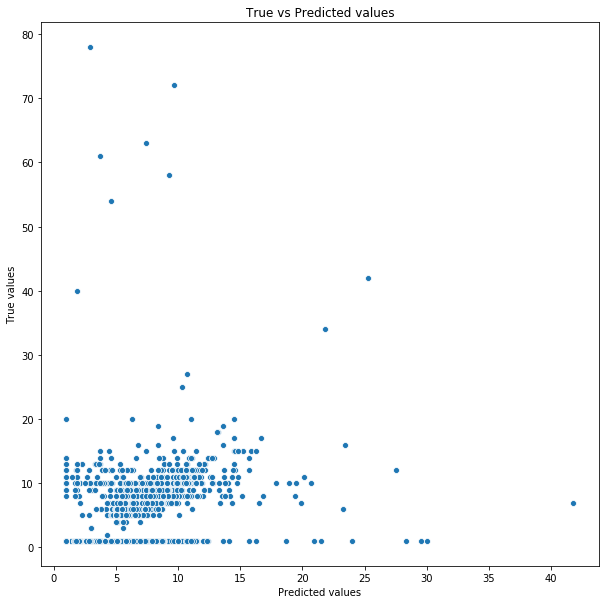

In [57]:
model = best_model(X_train, X_test, y_train, y_test,
                   [LinearRegression(), Lasso(), RandomForestRegressor()], 
                   plot=True, print_all=False)

**7. модель не работает, используем медиану для восстановления данных**

In [58]:
df = df_KitchenSquare.copy()

In [59]:
column = 'KitchenSquare'
ks_median = (df[(df['KitchenSquare']<df['Square'])&(df['KitchenSquare']!=0)].groupby(['DistrictSize'])[column].median()\
             /df[(df['KitchenSquare']<df['Square'])&(df['KitchenSquare']!=0)].groupby(['DistrictSize'])['Square'].median())\
             .reset_index().rename(columns={0:'temp_c'})
df_temp = df.merge(ks_median, on='DistrictSize', how='left')
df_temp.loc[df_temp['KitchenSquare']>df_temp['Square'],column]=df_temp['Square']*df_temp['temp_c']
df_temp.loc[df_temp['KitchenSquare']==0,column]=df_temp['Square']*df_temp['temp_c']
df = df_temp.drop(['temp_c'], axis=1)

In [60]:
#df = df_KitchenSquare.copy()
#print(df[target_].agg('mean'))
#print((df[target_]/df['Square']).agg('mean'))
#df.loc[df[target_]==0,target_] = df[target_].agg('median')
#df.loc[(df[target_]-df['Square'])>0,target_] = df['Square']*(df[target_]/df['Square']).agg('mean')

**Итого**

In [61]:
print('KitchenSquare wrong>LifeSquare\n', (df['KitchenSquare']-df['Square']>0).value_counts(), sep='')
print('\nKitchenSquare wrong==0\n', (df['KitchenSquare']==0).value_counts(), sep='')

KitchenSquare wrong>LifeSquare
False    15000
dtype: int64

KitchenSquare wrong==0
False    15000
Name: KitchenSquare, dtype: int64


In [62]:
df_KitchenSquare_new = df.copy()

### 2.5 HouseFloor

In [63]:
df = df_KitchenSquare_new.copy()
df_HouseFloor = df.copy()

In [64]:
#в чем проблема
print('HouseFloor wrong==0    - ', (df['HouseFloor']==0).value_counts()[1])

HouseFloor wrong==0    -  400


**1. определим цель и параметры**

In [65]:
# определяем таргет и параметры датасета 
# убираем параметры с некорретными значениями
feature_ = [
    #'Id', 
    #'DistrictId', 
    'Rooms', 
    'Square', 
    #'LifeSquare', 
    'KitchenSquare',
    #'Floor', 'HouseFloor', 
    'HouseYear', 
    'Ecology_1', 'Social_1', 'Social_2',
    'Social_3', 
    #'Healthcare_1', 
    'Helthcare_2', 'Shops_1', 
    #'Price',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
    'Shops_2_B', 'DistrictSize', 'IsDistrictLarge'
            ]
target_ = 'HouseFloor'

feature_std = df[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

**2. изучим распределение**

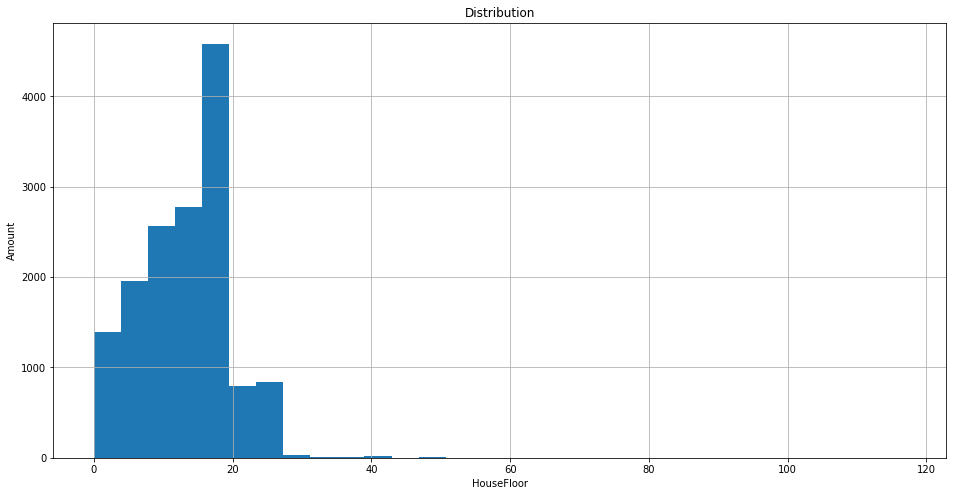

In [66]:
#df.info()
# изучем распределение
plt.figure(figsize = (16, 8))

df[target_].hist(bins=30)
plt.ylabel('Amount')
plt.xlabel(target_)

plt.title('Distribution')
plt.show()

**3. уберем выбросы**

In [67]:
#так как распределение похожа на нормальное и сильные выборсы, то почистим их)))
mean = df[target_].to_numpy().mean()
var = df[target_].to_numpy().var()**(1/2)
print(mean)
print(var)
print(len(df[df[target_]>(mean+3*var)]))
df.drop(df[df[target_]>(mean+3*var)].index.to_list(),inplace=True)
df.reset_index(inplace=True)

12.6066
6.7799387735681895
43


**4. определим тренировочный датасет**

In [68]:
df = df[df['HouseFloor']!=0].reset_index()
df.drop(['index'], axis=1, inplace=True)
df_train = df.copy()
#df_s.info()

**5. станартизируем и выделяем датасеты для модели**

In [69]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_std])
df[feature_std] = pd.DataFrame(scl_f, columns=feature_std)
X = df[feature_]
y = df[target_]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s_, random_state=random_st_)

**6. выберем лучшую модель**



BEST MODEL:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
R2:  0.426


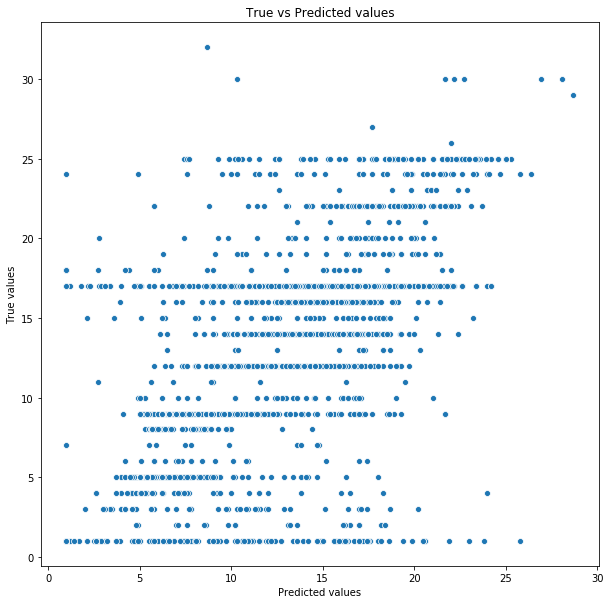

In [70]:
model = best_model(X_train, X_test, y_train, y_test,
                   [LinearRegression(), Lasso(), RandomForestRegressor()], 
                   plot=True, print_all=False)

**7. модель не работает, используем медиану для восстановления данных**

In [71]:
df = df_HouseFloor.copy()
column = 'HouseFloor'
ks_median = df[df[target_]!=0].groupby(['DistrictSize'])[column].median().reset_index().rename(columns={column:'temp_c'})
df_temp = df.merge(ks_median, on='DistrictSize', how='left')
df_temp.loc[df_temp[column]==0,column]=df_temp['temp_c']
df = df_temp.drop(['temp_c'], axis=1)

In [72]:
#df = df_HouseFloor.copy()
#print(df[target_].agg('median'))
#df.loc[df[target_]==0,target_] = df[target_].agg('median')

**Итого**

In [73]:
print('HouseFloor wrong==0\n', (df['HouseFloor']==0).value_counts(), sep='')

HouseFloor wrong==0
False    15000
Name: HouseFloor, dtype: int64


In [74]:
df_HouseFloor = df.copy()

### 2.6. LifeSquare

In [75]:
print('LifeSquare missed\n', pd.isna(df['LifeSquare']).value_counts(), sep='')
print('\nLifeSquare too small\n', (df['LifeSquare']<0.3*df['Square']).value_counts(),sep='')
print('\nLifeSquare bigger then Square\n', (df['LifeSquare']>df['Square']).value_counts(), sep='')

LifeSquare missed
False    11846
True      3154
Name: LifeSquare, dtype: int64

LifeSquare too small
False    14676
True       324
dtype: int64

LifeSquare bigger then Square
False    14289
True       711
dtype: int64


In [76]:
df = df_HouseFloor.copy()
df_LifeSquare = df.copy()

**1. определим цель и параметры**

In [77]:
# определяем таргет и параметры датасета 
# убираем параметры с некорретными значениями
feature_ = [
    #'Id', 
    #'DistrictId', 
    'Rooms', 
    'Square', 
    #'LifeSquare', 
    'KitchenSquare',
    #'Floor', 
    'HouseFloor', 'HouseYear', 
    'Ecology_1', 'Social_1', 'Social_2',
    'Social_3', 
    #'Healthcare_1', 
    'Helthcare_2', 'Shops_1', 
    #'Price',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
    'Shops_2_B', 'DistrictSize', 'IsDistrictLarge'
            ]
target_ = 'LifeSquare'

feature_std = df[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

**2. изучим распределение**

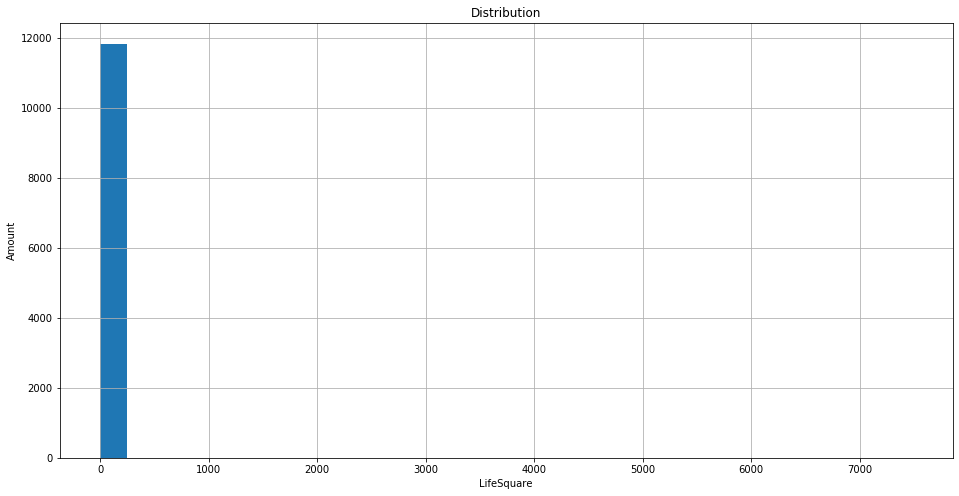

In [78]:
#df.info()
# изучем распределение
plt.figure(figsize = (16, 8))

df[target_].hist(bins=30)
plt.ylabel('Amount')
plt.xlabel(target_)

plt.title('Distribution')
plt.show()

**3. определим тренировочный датасет**

In [79]:
df = df[pd.isna(df['LifeSquare'])== False].reset_index()
df.drop(['index'],axis=1, inplace=True)
df = df[(df['LifeSquare']>0.3*df['Square'])].reset_index()
df.drop(['index'],axis=1, inplace=True)
df = df[df['LifeSquare']<df['Square']].reset_index()
df.drop(['index'],axis=1, inplace=True)
df.info()
df_train = df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10811 entries, 0 to 10810
Data columns (total 25 columns):
Id                 10811 non-null int64
DistrictId         10811 non-null object
Rooms              10811 non-null float64
Square             10811 non-null float64
LifeSquare         10811 non-null float64
KitchenSquare      10811 non-null float64
Floor              10811 non-null int64
HouseFloor         10811 non-null float64
HouseYear          10811 non-null float64
Ecology_1          10811 non-null float64
Social_1           10811 non-null int64
Social_2           10811 non-null int64
Social_3           10811 non-null int64
Healthcare_1       6282 non-null float64
Helthcare_2        10811 non-null int64
Shops_1            10811 non-null int64
Price              7202 non-null float64
Ecology_2_A        10811 non-null uint8
Ecology_2_B        10811 non-null uint8
Ecology_3_A        10811 non-null uint8
Ecology_3_B        10811 non-null uint8
Shops_2_A          10811 non-null 

**4. уберем выбросы**

In [80]:
#так как распределение похожа на нормальное и сильные выборсы, то почистим их)))
mean = df[target_].to_numpy().mean()
var = df[target_].to_numpy().var()**(1/2)
print(mean)
print(var)
print(len(df[df[target_]>(mean+3*var)]))
df.drop(df[df[target_]>(mean+3*var)].index.to_list(),inplace=True)
df.reset_index(inplace=True)

35.43831864193018
16.318086993331654
125


**5. станартизируем и выделяем датасеты для модели**

In [81]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_std])
df[feature_std] = pd.DataFrame(scl_f, columns=feature_std)
X = df[feature_]
y = df[target_]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s_, random_state=random_st_)

**6. выберем лучшую модель**



BEST MODEL:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
R2:  0.852


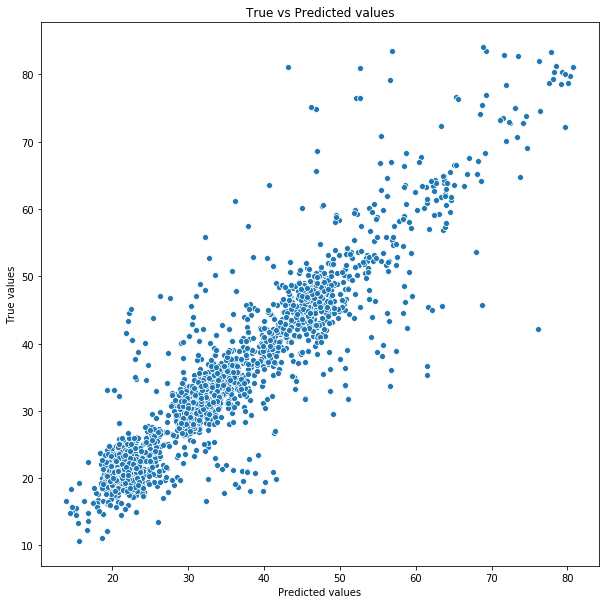

In [82]:
model = best_model(X_train, X_test, y_train, y_test,
                   [LinearRegression(), Lasso(), RandomForestRegressor()], 
                   plot=True, print_all=False)

**7. подберем оптимальные параметры для модели**

In [83]:
#model = model
param={'n_estimators':[100, 150, 300], 'max_depth':[9, 12, 15]}
gd=GridSearchCV(model, param, scoring='r2',cv = KFold(n_splits=3,random_state = 42))
gd.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,

In [84]:
gd.best_params_

{'max_depth': 12, 'n_estimators': 300}

In [85]:
model_1 = RandomForestRegressor(max_depth=gd.best_params_['max_depth'], 
                                       n_estimators=gd.best_params_['n_estimators'], 
                                       random_state=random_st_
                                      )
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.975
MAE:	1.202
MSE:	4.606


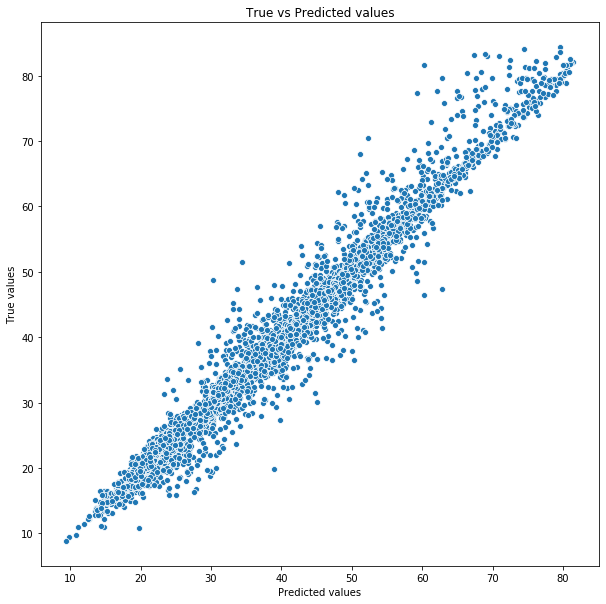

R2:	0.852
MAE:	3.055
MSE:	25.516


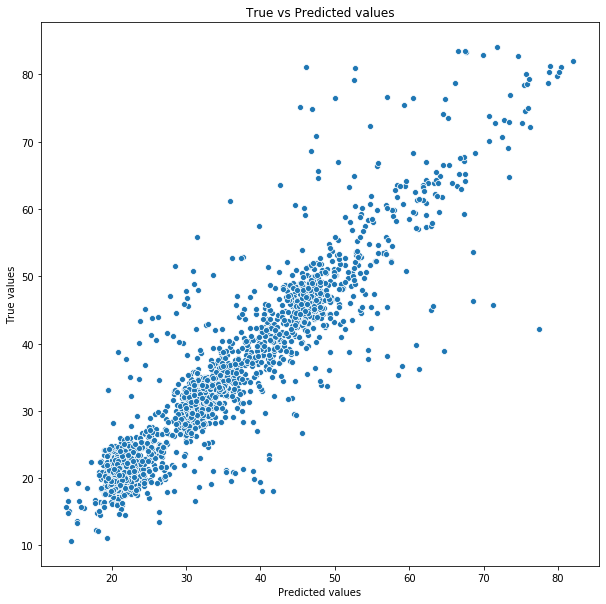

In [86]:
y_pred = model.predict(X_train)
evaluate_preds(y_train, y_pred)

y_pred_t = model.predict(X_test)
evaluate_preds(y_test, y_pred_t)

**8. восстанавливаем данные**

In [87]:
df = df_LifeSquare.copy()

df = pd.concat([df[pd.isna(df['LifeSquare'])== True].reset_index(),
                df[(df['LifeSquare']<=0.3*df['Square'])].reset_index(),
                df[df['LifeSquare']>df['Square']].reset_index()])

In [88]:
df_std = df.copy()
scl_f = scl.transform(df_std[feature_std])
df_std[feature_std] = pd.DataFrame(scl_f, columns=feature_std)

X = df_std[feature_]
target = model.predict(X)

df[target_] =  pd.DataFrame(target)

In [89]:
df = pd.concat([df_train, df], ignore_index=True)
df = df[columns_full]

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 25 columns):
Id                 15000 non-null int64
DistrictId         15000 non-null object
Rooms              15000 non-null float64
Square             15000 non-null float64
LifeSquare         15000 non-null float64
KitchenSquare      15000 non-null float64
Floor              15000 non-null int64
HouseFloor         15000 non-null float64
HouseYear          15000 non-null float64
Ecology_1          15000 non-null float64
Social_1           15000 non-null int64
Social_2           15000 non-null int64
Social_3           15000 non-null int64
Healthcare_1       7825 non-null float64
Helthcare_2        15000 non-null int64
Shops_1            15000 non-null int64
Price              10000 non-null float64
Ecology_2_A        15000 non-null uint8
Ecology_2_B        15000 non-null uint8
Ecology_3_A        15000 non-null uint8
Ecology_3_B        15000 non-null uint8
Shops_2_A          15000 non-null

**9. итого 1.:**

In [91]:
print('LifeSquare missed\n', pd.isna(df['LifeSquare']).value_counts(), sep='')
print('\nLifeSquare too small\n', (df['LifeSquare']<0.3*df['Square']).value_counts(),sep='')
print('\nLifeSquare bigger then Square\n', (df['LifeSquare']>df['Square']).value_counts(), sep='')

LifeSquare missed
False    15000
Name: LifeSquare, dtype: int64

LifeSquare too small
False    14981
True        19
dtype: int64

LifeSquare bigger then Square
False    14587
True       413
dtype: int64


**10. оставшиеся данные заменим средними значениями из DistrictId**

In [92]:
column = 'LifeSquare'
ks_median = (df[(df['LifeSquare']>0.3*df['Square'])&(df['LifeSquare']<df['Square'])].groupby(['DistrictSize'])[column].median()\
             /df[(df['LifeSquare']>0.3*df['Square'])&(df['LifeSquare']<df['Square'])].groupby(['DistrictSize'])['Square'].median())\
             .reset_index().rename(columns={0:'temp_c'})
df_temp = df.merge(ks_median, on='DistrictSize', how='left')
df_temp.loc[df_temp['LifeSquare']<0.3*df_temp['Square'],column]=df_temp['Square']*df_temp['temp_c']
df_temp.loc[df_temp['LifeSquare']>df_temp['Square'],column]=df_temp['Square']*df_temp['temp_c']
df = df_temp.drop(['temp_c'], axis=1)

In [93]:
#df.loc[df['LifeSquare']<0.3*df['Square'], 'LifeSquare'] = df['Square']*(df['LifeSquare']/df['Square']).agg('mean')
#df.loc[df['LifeSquare']>df['Square'], 'LifeSquare'] = df['Square']*(df['LifeSquare']/df['Square']).agg('mean')

**10. итого 2.:**

In [94]:
print('LifeSquare missed\n', pd.isna(df['LifeSquare']).value_counts(), sep='')
print('\nLifeSquare too small\n', (df['LifeSquare']<0.3*df['Square']).value_counts(),sep='')
print('\nLifeSquare bigger then Square\n', (df['LifeSquare']>df['Square']).value_counts(), sep='')

LifeSquare missed
False    15000
Name: LifeSquare, dtype: int64

LifeSquare too small
False    15000
dtype: int64

LifeSquare bigger then Square
False    15000
dtype: int64


In [95]:
df_LifeSquare = df.copy()

### 2.7. Floor

In [96]:
df = df_LifeSquare.copy()
df_Floor = df.copy()

In [97]:
#в чем проблема
print('Floor wrong Floor>HouseFloor\n', (df['HouseFloor']<df['Floor']).value_counts(), sep='')

Floor wrong Floor>HouseFloor
False    12634
True      2366
dtype: int64


**1. определим цель и параметры**

In [98]:
# определяем таргет и параметры датасета 
# убираем параметры с некорретными значениями
feature_ = [
    #'Id', 
    #'DistrictId', 
    'Rooms', 
    'Square', 'LifeSquare', 'KitchenSquare',
    #'Floor', 
    'HouseFloor', 
    'HouseYear', 
    'Ecology_1', 'Social_1', 'Social_2',
    'Social_3', 
    #'Healthcare_1', 
    'Helthcare_2', 'Shops_1', 
    #'Price',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
    'Shops_2_B', 'DistrictSize', 'IsDistrictLarge'
            ]
target_ = 'Floor'

feature_std = df[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

**2. изучим распределение**

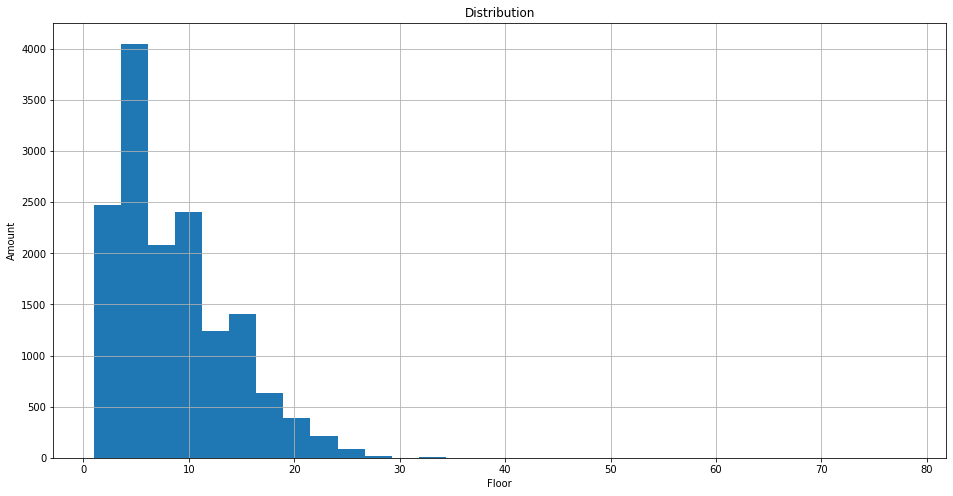

In [99]:
#df.info()
# изучем распределение
plt.figure(figsize = (16, 8))

df[target_].hist(bins=30)
plt.ylabel('Amount')
plt.xlabel(target_)

plt.title('Distribution')
plt.show()

**3. определим тренировочный датасет**

In [100]:
df = df[df['HouseFloor']>df['Floor']].reset_index()
df.drop(['index'], axis=1, inplace=True)
df_train = df.copy()
#df_s.info()

**4. уберем выбросы**

In [101]:
#так как распределение похожа на нормальное и сильные выборсы, то почистим их)))
mean = df[target_].to_numpy().mean()
var = df[target_].to_numpy().var()**(1/2)
print(mean)
print(var)
print(len(df[df[target_]>(mean+3*var)]))
df.drop(df[df[target_]>(mean+3*var)].index.to_list(),inplace=True)
df.reset_index(inplace=True)

7.750066922459177
4.808818761666557
84


**5. станартизируем и выделяем датасеты для модели**

In [102]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_std])
df[feature_std] = pd.DataFrame(scl_f, columns=feature_std)
X = df[feature_]
y = df[target_]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s_, random_state=random_st_)

**6. выберем лучшую модель**



BEST MODEL:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
R2:  0.33


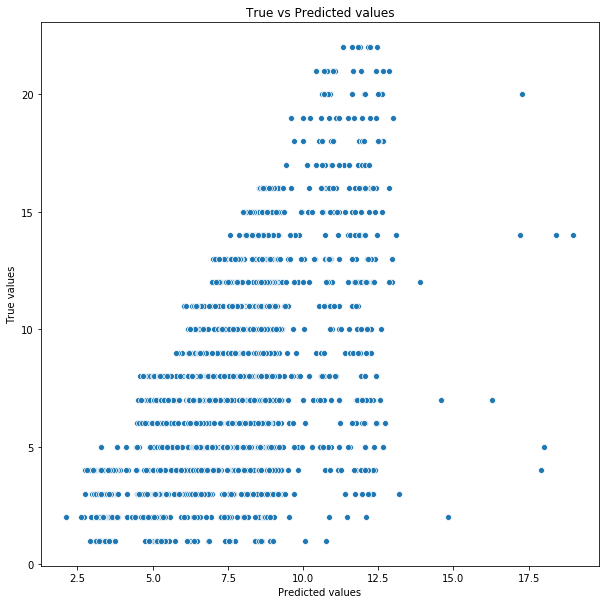

In [103]:
model = best_model(X_train, X_test, y_train, y_test,
                   [LinearRegression(), Lasso(), RandomForestRegressor()], 
                   plot=True, print_all=False)

**7. модель не работает, используем среднее для восстановления**

In [104]:
df = df_Floor.copy()

In [105]:
column = 'Floor'
ks_median = (df[(df['HouseFloor']>df['Floor'])].groupby(['DistrictSize'])[column].median()\
             /df[(df['HouseFloor']>df['Floor'])].groupby(['DistrictSize'])['HouseFloor'].median())\
             .reset_index().rename(columns={0:'temp_c'})
df_temp = df.merge(ks_median, on='DistrictSize', how='left')
df_temp.loc[(df['HouseFloor']<df['Floor']),column]=df_temp['HouseFloor']*df_temp['temp_c']
df = df_temp.drop(['temp_c'], axis=1)

In [106]:
#df.loc[df['Floor']>df['HouseFloor'], 'Floor'] = (round(df['HouseFloor']*(df.loc[df['Floor']<df['HouseFloor'], 'Floor'].agg('median'))\
                                                #/(df.loc[df['Floor']<df['HouseFloor'], 'HouseFloor'].agg('median'))))

In [107]:
#в чем проблема
print('Floor wrong Floor>HouseFloor\n', (df['HouseFloor']<df['Floor']).value_counts(), sep='')

Floor wrong Floor>HouseFloor
False    15000
dtype: int64


In [108]:
df_Floor = df.copy()

### 2.8. HealthCare_1

In [109]:
df = df_Floor.copy()
df_HealthCare_1 = df.copy()

In [110]:
# в чем проблема
print('Healthcare_1 missed\n', pd.isna(df['Healthcare_1']).value_counts(), sep='')

Healthcare_1 missed
False    7825
True     7175
Name: Healthcare_1, dtype: int64


**1. определим цель и параметры**

In [111]:
# определяем таргет и параметры датасета 
# убираем параметры с некорретными значениями
feature_ = [
    #'Id', 
    #'DistrictId', 
    'Rooms', 
    'Square', 'LifeSquare', 'KitchenSquare',
    'Floor', 'HouseFloor', 
    'HouseYear', 
    'Ecology_1', 'Social_1', 'Social_2',
    'Social_3', 
    #'Healthcare_1', 
    'Helthcare_2', 'Shops_1', 
    #'Price',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
    'Shops_2_B', 'DistrictSize', 'IsDistrictLarge'
            ]
target_ = 'Healthcare_1'

feature_std = df[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

**2. изучим распределение**

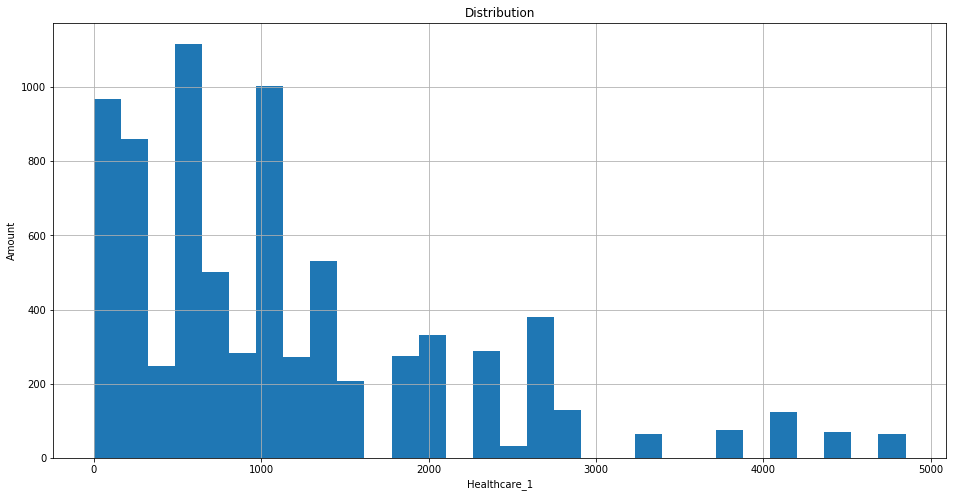

In [112]:
#df.info()
# изучем распределение
plt.figure(figsize = (16, 8))

df[target_].hist(bins=30)
plt.ylabel('Amount')
plt.xlabel(target_)

plt.title('Distribution')
plt.show()

**3. определим тренировочный датасет**

In [113]:
df = df[pd.isna(df['Healthcare_1']) == False].reset_index()
df.drop(['index'], axis=1, inplace=True)
df_train = df.copy()
#df.info()

**4. станартизируем и выделяем датасеты для модели**

In [114]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_std])
df[feature_std] = pd.DataFrame(scl_f, columns=feature_std)
X = df[feature_]
y = df[target_]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s_, random_state=random_st_)

**5. выберем лучшую модель**



BEST MODEL:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
R2:  0.996


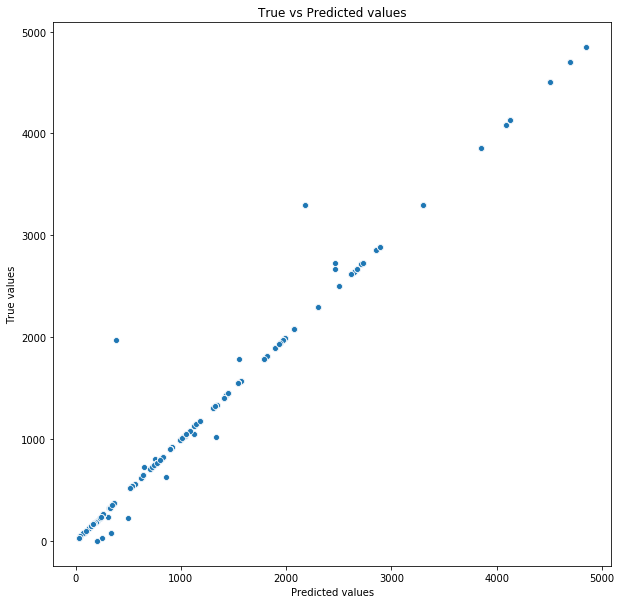

In [115]:
model = best_model(X_train, X_test, y_train, y_test,
                   [LinearRegression(), Lasso(), RandomForestRegressor()], 
                   plot=True, print_all=False)

**6. восстанавливаем данные**

In [116]:
df = df_HealthCare_1.copy()

df = df[pd.isna(df['Healthcare_1']) == True].reset_index()
df.drop(['index'], axis=1, inplace=True)

In [117]:
df_std = df.copy()
scl_f = scl.transform(df_std[feature_std])
df_std[feature_std] = pd.DataFrame(scl_f, columns=feature_std)

X = df_std[feature_]
target = model.predict(X)

df[target_] =  pd.DataFrame(target)

In [118]:
#df = pd.concat([df_square[df_square[target_]>=10], df], ignore_index=True)
df = pd.concat([df_train, df], ignore_index=True)
df = df[columns_full]

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 25 columns):
Id                 15000 non-null int64
DistrictId         15000 non-null object
Rooms              15000 non-null float64
Square             15000 non-null float64
LifeSquare         15000 non-null float64
KitchenSquare      15000 non-null float64
Floor              15000 non-null float64
HouseFloor         15000 non-null float64
HouseYear          15000 non-null float64
Ecology_1          15000 non-null float64
Social_1           15000 non-null int64
Social_2           15000 non-null int64
Social_3           15000 non-null int64
Healthcare_1       15000 non-null float64
Helthcare_2        15000 non-null int64
Shops_1            15000 non-null int64
Price              10000 non-null float64
Ecology_2_A        15000 non-null uint8
Ecology_2_B        15000 non-null uint8
Ecology_3_A        15000 non-null uint8
Ecology_3_B        15000 non-null uint8
Shops_2_A          15000 non-n

In [120]:
df_HealthCare_1 = df.copy()

**7. итого:**

In [121]:
print('Healthcare_1 missed\n', pd.isna(df['Healthcare_1']).value_counts(), sep='')

Healthcare_1 missed
False    15000
Name: Healthcare_1, dtype: int64


### 3.0 Price

In [122]:
df = df_HealthCare_1.copy()
df_Price = df.copy()

In [123]:
#в чем проблема
print('Square wrong\n', pd.isna(df['Price']).value_counts(), sep='')

Square wrong
False    10000
True      5000
Name: Price, dtype: int64


**1. определим цель и параметры**

In [124]:
# определяем таргет и параметры датасета 
# убираем параметры с некорретными значениями
feature_ = [
    #'Id', 
    #'DistrictId', 
    'Rooms', 
    'Square', 'LifeSquare', 'KitchenSquare',
    'Floor', 'HouseFloor', 
    'HouseYear', 
    'Ecology_1', 'Social_1', 'Social_2',
    'Social_3', 
    'Healthcare_1', 
    'Helthcare_2', 'Shops_1', 
    #'Price',
    'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A',
    'Shops_2_B', 'DistrictSize', 'IsDistrictLarge'
            ]
target_ = 'Price'

feature_std = df[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

**2. изучим распределение**

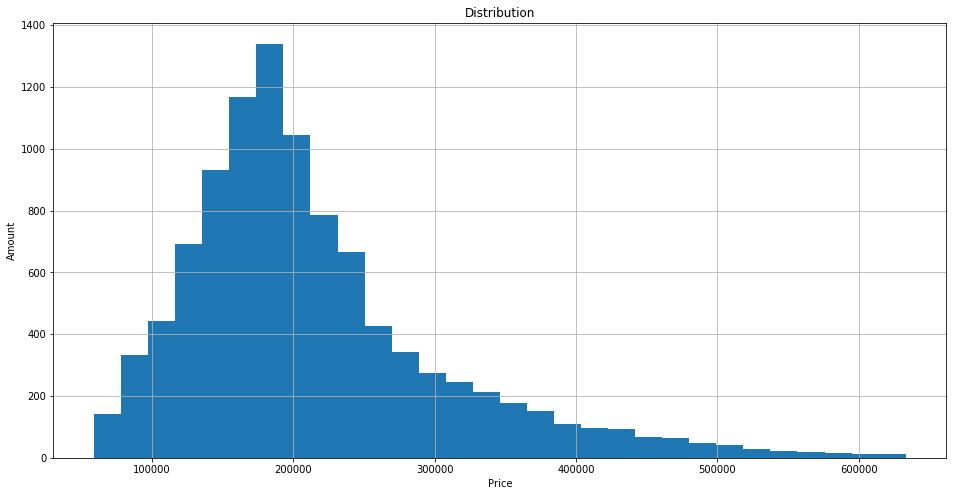

In [125]:
#df.info()
# изучем распределение
plt.figure(figsize = (16, 8))

df[target_].hist(bins=30)
plt.ylabel('Amount')
plt.xlabel(target_)

plt.title('Distribution')
plt.show()

**3. определим тренировочный датасет**

In [126]:
df = df[pd.isna(df['Price']) == False].reset_index()
df.drop(['index'], axis=1, inplace=True)
df_train = df.copy()
#df.info()

**4. станартизируем и выделяем датасеты для модели**

In [127]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_std])
df[feature_std] = pd.DataFrame(scl_f, columns=feature_std)
X = df[feature_]
y = df[target_]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_s_, random_state=random_st_)

**5. выберем лучшую модель**



BEST MODEL:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False) 
R2:  0.729


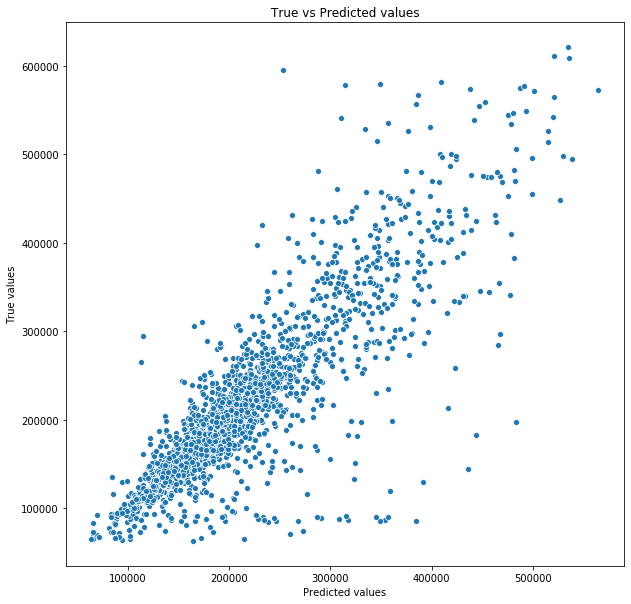

In [128]:
model = best_model(X_train, X_test, y_train, y_test,
                   [LinearRegression(), Lasso(), RandomForestRegressor()], 
                   plot=True, print_all=False)

**6. подберем оптимальные параметры для модели**

In [129]:
#model = model
param={'n_estimators':[300, 450], 'max_depth':[ 12, 15]}
gd=GridSearchCV(model, param, scoring='r2',cv = KFold(n_splits=3,random_state = 42))
gd.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,

In [130]:
gd.best_params_

{'max_depth': 15, 'n_estimators': 300}

In [131]:
model_1 = RandomForestRegressor(max_depth=gd.best_params_['max_depth'], 
                                       n_estimators=gd.best_params_['n_estimators'], 
                                       random_state=random_st_
                                      )
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.947
MAE:	12054.365
MSE:	447966295.067


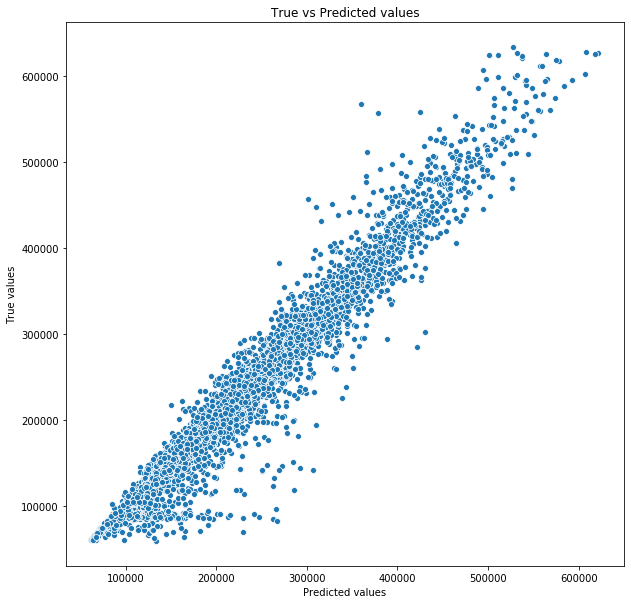

R2:	0.73
MAE:	30065.384
MSE:	2449708259.881


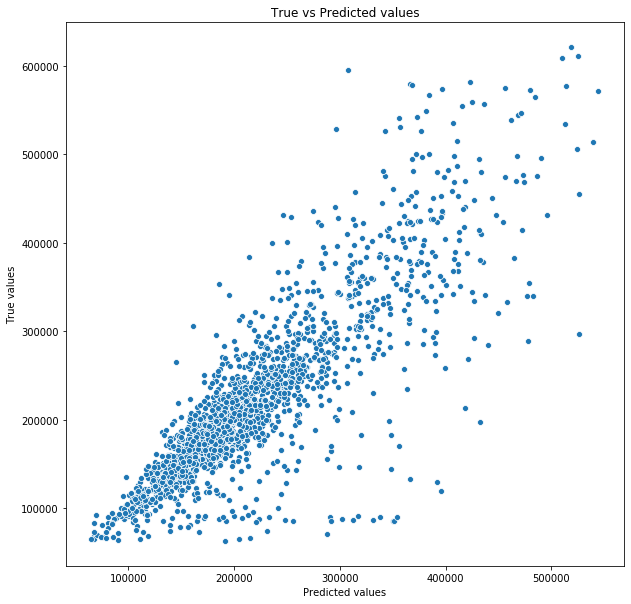

In [132]:
y_pred = model.predict(X_train)
evaluate_preds(y_train, y_pred)

y_pred_t = model.predict(X_test)
evaluate_preds(y_test, y_pred_t)

**7. восстанавливаем данные**

In [133]:
df = df_Price.copy()

df = df[pd.isna(df['Price']) == True].reset_index()
df.drop(['index'], axis=1, inplace=True)

In [134]:
df_std = df.copy()
scl_f = scl.transform(df_std[feature_std])
df_std[feature_std] = pd.DataFrame(scl_f, columns=feature_std)

X = df_std[feature_]
target = model.predict(X)

df[target_] =  pd.DataFrame(target)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
Id                 5000 non-null int64
DistrictId         5000 non-null object
Rooms              5000 non-null float64
Square             5000 non-null float64
LifeSquare         5000 non-null float64
KitchenSquare      5000 non-null float64
Floor              5000 non-null float64
HouseFloor         5000 non-null float64
HouseYear          5000 non-null float64
Ecology_1          5000 non-null float64
Social_1           5000 non-null int64
Social_2           5000 non-null int64
Social_3           5000 non-null int64
Healthcare_1       5000 non-null float64
Helthcare_2        5000 non-null int64
Shops_1            5000 non-null int64
Price              5000 non-null float64
Ecology_2_A        5000 non-null uint8
Ecology_2_B        5000 non-null uint8
Ecology_3_A        5000 non-null uint8
Ecology_3_B        5000 non-null uint8
Shops_2_A          5000 non-null uint8
Shops_2_B     

In [136]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictSize,IsDistrictLarge
0,5502,32,2.0,48.193897,32.857644,6.0,5.0,14.0,1972.0,0.135650,...,11,247191.363625,0,1,0,1,0,1,55,0
1,11538,6,3.0,80.219400,47.660260,9.0,13.0,17.0,2014.0,0.243205,...,0,219903.233116,0,1,0,1,0,1,768,1
2,9286,3,1.0,34.743457,19.772110,6.0,5.0,9.0,1971.0,0.265089,...,2,143251.744278,0,1,0,1,0,1,138,1
3,11260,46,2.0,46.813776,31.883008,5.0,4.0,5.0,1968.0,0.000000,...,5,173881.279139,0,1,0,1,0,1,180,1
4,11307,41,1.0,42.267225,21.465927,9.0,7.0,14.0,1974.0,0.036122,...,1,207438.415509,0,1,0,1,0,1,131,1


In [137]:
result = df[['Id','Price']]
result.head()

,Id,Price
0,5502,247191.363625
1,11538,219903.233116
2,9286,143251.744278
3,11260,173881.279139
4,11307,207438.415509


In [138]:
result.to_csv('AYarkov_predictions.csv', sep=',', header=True)